In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, pickle, time, sys
import mne
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
from utils import *
# %matplotlib qt
import neurokit2 as nk
from scipy.stats import entropy
from scipy import polyfit
# from scipy import stats
from pyentrp import entropy as ent
from scipy.signal import welch, find_peaks, savgol_filter
from pyentrp import entropy as ent
from scipy.stats import moment
from scipy.signal import butter, lfilter
# from PyEMD import EMD
import pywt
import nolds
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = (10,8)
from tqdm.notebook import tqdm

In [58]:
MODE = 'MR'
POLYFIT_DEGREE = 2
ENABLE_FILTER = True

def read_emg_csv(parent_folder, folder, filename):
    path = os.path.join(parent_folder, folder, filename)
    if os.path.exists(path):
        df = pd.read_csv(path)
        # markers = df[' Marker'].unique()
        # # print(markers)
        # # count = df[' Marker'].value_counts()
        # # print(count)
        data = {}
        myo_elctrodes = ['C1', 'C2', 'C3','C4', 'C5', 'C6', 'C7', 'C8']
        # for i , (dir, s,e) in enumerate(zip(['Y' , 'Z', 'X'],[1000, 2000, 3000], [1001, 2001, 3001])):
        #     start_row_indices = df[df['Marker'] == s].index
        #     end_row_indices = df[df['Marker'] == e].index
        #     data[f'TskDir_{dir}'] = []
        #     for start, end in zip(start_row_indices, end_row_indices):
        #         data[f'TskDir_{dir}'].append(df.iloc[start + 1: end][myo_elctrodes].values)
        
        start_row_indices = df[df['Marker'] == 'START_DRAW'].index
        stop_row_indices = df[df['Marker'] == 'STOP_DRAW'].index
        inner_data = []
        outer_data = []
        count = 0
        for start, stop in zip(start_row_indices, stop_row_indices):
            if count % 2 == 0:
                outer_data.append(df.iloc[start + 1: stop][myo_elctrodes].values)
            else:
                inner_data.append(df.iloc[start + 1: stop][myo_elctrodes].values)
            count += 1

        # print(f"Successfully read EMG.csv in {os.path.join(parent_folder, folder, 'Myo', subfolder)}")
        data['Inner'] = inner_data
        data['Outer'] = outer_data
        return data
    else:
        # print(f"EMG.csv not found in {os.path.join(parent_folder, folder, 'Myo', subfolder)}")
        return None
    
parent_folder_path = f'D:/VIP_MRTK3/EMG_Data/New/{MODE}'
# subfolder_names = ["ControllerAndPen", "TwoControllers", "TwoHand"]
EMG_Dataset = {}
for folder in os.listdir(parent_folder_path):
    # check if the folder is a directory and some file exists
    if os.path.isdir(os.path.join(parent_folder_path, folder)):
        EMG_Dataset[f'{folder}'] = {}
        for filename in os.listdir(os.path.join(parent_folder_path, folder)):
            if not filename.endswith('.csv'):
                continue
            
            EMG_Dataset[f'{folder}'][f'{filename.split("_")[1]}'] = read_emg_csv(parent_folder_path, folder, filename)
    
    # if os.path.isdir(os.path.join(parent_folder_path, folder)):
    #     EMG_Dataset[f'{folder}'] = {}
    #     for subfolder in subfolder_names:
    #         EMG_Dataset[f'{folder}'][f'{subfolder}'] = read_emg_csv(parent_folder_path, folder, subfolder)
            
print(EMG_Dataset.keys())       
# print(EMG_Dataset['P02'].keys())
# print(EMG_Dataset['P02']['ARController'].keys())
# print(len(EMG_Dataset['P01']['MRController']['Outer']))

dict_keys(['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12'])


In [59]:
#================================================================================
#                            [Butter Bandpass]
#================================================================================
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


#================================================================================
#                            [Willison Amplitude]
#================================================================================
def cal_willison_amplitude(emg_data, threshold=0.1):
    'emg shape: [pnts, channel]'
    diff_data = np.diff(emg_data, axis=0)
    wamp = np.sum(np.abs(diff_data) > threshold, axis=0)
    return wamp


#================================================================================
#                            [Simple Square Integral]
#================================================================================
def cal_simple_square_integral(emg_data):
    'emg shape: [pnts, channel]'
    ssi = np.sum(emg_data ** 2, axis=0)
    return ssi


#================================================================================
#                            [Integrated EMG]
#================================================================================
def cal_integrated_emg(emg_data):
    'emg shape: [pnts, channel]'
    iemg = np.sum(np.abs(emg_data), axis=0)
    return iemg


#================================================================================
#                            [Mean Absolute Value]
#================================================================================

def cal_mav(emg_data):
    'emg shape: [pnts, channel]'
    mav = np.mean(np.abs(emg_data), axis=0)
    return mav

#================================================================================
#                            [Root Mean Square]
#================================================================================
def cal_root_mean_square(emg_data):
    'emg shape: [pnts, channel]'
    rms = np.sqrt(np.mean(emg_data ** 2, axis=0))
    return rms


#================================================================================
#                            [Median Frequency]
#================================================================================
def cal_median_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mdf = []
    for elec_idx in range(emg_data.shape[1]):
        electrode_data = emg_data[:, elec_idx]
        freqs, Pxx = welch(electrode_data, fs, nperseg=nperseg)
        cumsum = np.cumsum(Pxx)
        median_freq = freqs[np.where(cumsum >= cumsum[-1] / 2)[0][0]]
        mdf.append(median_freq)
    mdf = np.array(mdf)
    return mdf


#================================================================================
#                            [Mean Frequency]
#================================================================================
def cal_mean_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mnf = []
    for elec_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, elec_idx], fs, nperseg=nperseg)
        mnf.append(np.sum(f * Pxx) / np.sum(Pxx))
    mnf = np.array(mnf)
    return mnf


#================================================================================
#                            [Peak Frequency]
#================================================================================
def cal_peak_frequency(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    pkf = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        pkf.append(f[np.argmax(Pxx)])
    pkf = np.array(pkf)
    return pkf


#================================================================================
#                            [Mean Power]
#================================================================================
def cal_mean_power(emg_data, fs=200, nperseg=200):
    mnp = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        mnp.append(np.mean(Pxx))

    mnp = np.array(mnp)
    return mnp


#================================================================================
#                            [Total Power]
#================================================================================
def cal_total_power(emg_data, fs=200, nperseg=200):
    ttp = []
    for ch_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, ch_idx], fs, nperseg=nperseg)
        ttp.append(np.sum(Pxx))
    ttp = np.array(ttp)

    return ttp


#================================================================================
#                            [Waveform Lenght]
#================================================================================
def cal_waveform_length(emg_data):
    'emg shape: [pnts, channel]'
    wl = np.sum(np.abs(np.diff(emg_data, axis=0)), axis=0)
    return wl


#================================================================================
#                            [Sample Entropy]
#================================================================================
def cal_sample_entropy(emg_data, m=2, r=0.2):
    'emg shape: [pnts, channel]'
    sentropy = []
    for elec_idx in range(emg_data.shape[1]):
        se = ent.sample_entropy(emg_data[:, elec_idx], m, r)
        sentropy.append(se[-1])  # Use the last value (m = 2)
    return np.array(sentropy)


#================================================================================
#                            [Slop Sign Change]
#================================================================================
def cal_slope_sign_changes(emg_data):
    'emg shape: [pnts, channel]'
    diff_data = np.diff(emg_data, axis=0)
    ssc = np.sum((diff_data[:-1, :] * diff_data[1:, :]) < 0, axis=0)
    return ssc


#================================================================================
#                            [Zero Crossing Rate]
#================================================================================
def cal_zero_crossing_rate(emg_data):
    'emg shape: [pnts, channel]'
    zcr = np.sum((emg_data[:-1, :] * emg_data[1:, :]) < 0, axis=0)
    return zcr


#================================================================================
#                            [Hjorth]
#================================================================================
def cal_hjorth_parameters(emg_data):
    'emg shape: [pnts, channel]'
    first_derivative = np.diff(emg_data, axis=0)
    second_derivative = np.diff(first_derivative, axis=0)

    activity = np.mean(emg_data ** 2, axis=0)
    mobility = np.mean(first_derivative ** 2, axis=0) / activity
    complexity = (np.mean(second_derivative ** 2, axis=0) / np.mean(first_derivative ** 2, axis=0)) / mobility

    return activity, mobility, complexity


#================================================================================
#                            [Spectral Moments]
#================================================================================
def cal_spectral_moments(emg_data, fs=200, nperseg=200):
    'emg shape: [pnts, channel]'
    mean_frequency, variance_frequency = [], []

    for elec_idx in range(emg_data.shape[1]):
        f, Pxx = welch(emg_data[:, elec_idx], fs=fs, nperseg=nperseg)
        mean_freq = np.sum(f * Pxx) / np.sum(Pxx)
        mean_frequency.append(mean_freq)
        variance_frequency.append(moment(Pxx, moment=2))

    mean_frequency = np.array(mean_frequency)
    variance_frequency = np.array(variance_frequency)

    return mean_frequency, variance_frequency


#================================================================================
#                            [Wavelet Transform]
#================================================================================

def cal_wavelet_transform(emg_data, wavelet='db4'):
    'emg shape: [pnts, channel]'

    wavelet_coeffs_list = pywt.wavedec(emg_data, wavelet, axis=0)

    return wavelet_coeffs_list


#================================================================================
#                            [Deterended Fluctuations Analysis]
#================================================================================

def cal_detrended_fluctuation_analysis(emg_data):
    'emg shape: [pnts, channel]'
    dfa = []
    for elec_idx in range(emg_data.shape[1]):
        dfa.append(nolds.dfa(emg_data[:, elec_idx]))
    return np.array(dfa)


#================================================================================
#                            [Windowing]
#================================================================================

def window_emg_data(emg_data, fs, window_length, overlap=0):
    'emg shape: [pnts, channel]'
    num_samples, num_electrodes = emg_data.shape
    window_length = int(window_length * fs)
    overlap = int(overlap * fs)
    step_size = window_length - overlap
    num_windows = int((num_samples - overlap) / step_size)

    windowed_emg_data = np.empty((int(window_length), int(num_windows), int(num_electrodes)))

    for win_idx in range(num_windows):
        start_sample = win_idx * step_size
        end_sample = start_sample + window_length
        windowed_emg_data[:, win_idx, :] = emg_data[start_sample:end_sample, :]
    return windowed_emg_data


#================================================================================
#                            [Plot EMG]
#================================================================================

def plot_emg(data_list, fig_size=(12, 8), scale=1.01, ylim=None):
    'data is a list of inputs with shape of [pnts, channel]'

    channel = data_list[0].shape[1]
    channel_max = 0.0
    fig, ax = plt.subplots(channel, 1, sharex=True, figsize=fig_size)
    for i in range(channel):
        for j in range(len(data_list)):
            data = data_list[j]
            ax[i].plot(data[:, i], linewidth=0.5)
            if ylim is None:
                channel_max_cur = np.max(np.abs(data[:, i])) * scale
                if channel_max_cur > channel_max:
                    channel_max = channel_max_cur
                ax[i].set_ylim(-channel_max, channel_max)
            else:
                ax[i].set_ylim(ylim[0], ylim[1])
            ax[i].set_ylabel(f'Channel {i + 1}')
            if i == channel - 1:
                ax[i].set_xlabel('Time')
    plt.tight_layout()
    plt.show()


#================================================================================
#                            [EMG Trend]
#================================================================================ 

def regressor(data, fs=200, regressor='linear', plot_trend=False):
    'data shape: [pnts, channel]'
    time = np.arange(0, len(data))
    num_channels = data.shape[1]

    regression_models, regression_slopes = [], []
    for i in range(num_channels):
        channel_data = data[:, i].reshape(-1, 1)
        time_reshaped = time.reshape(-1, 1)

        if regressor == 'linear':
            # linear regressor
            model = LinearRegression()
            model.fit(time_reshaped, channel_data)
            regression_models.append(model)
            regression_slopes.append(model.coef_[0])

        elif regressor == 'svr':
            # Support vector regressor 
            model = SVR(kernel='rbf', C=1e3, gamma=0.1)
            model.fit(time_reshaped, channel_data.ravel())
            regression_models.append(model)

        elif regressor == 'rf':
            # RF regressor 
            model = RandomForestRegressor(n_estimators=100, random_state=0)
            model.fit(time_reshaped, channel_data.ravel())
            regression_models.append(model)
        else:
            raise 'TypeError' "current regressors are 'linear' | 'svr' | 'rf'"

    # Visualize the fitted regression curves
    # fitted_curve = np.array([model.predict(time_reshaped).squeeze() for model in regression_models])
    # plot_emg([data, fitted_curve.T])
    if plot_trend:
        if num_channels == 1:
            fig, ax = plt.subplots(figsize=(10, 5))
            axs = [ax]
        else:
            fig, axs = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels))

        # fig, axs = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels))
        for i, model in enumerate(regression_models):
            channel_data = data[:, i]
            fitted_curve = model.predict(time_reshaped)

            axs[i].plot(time, channel_data, label='EMG Channel {}'.format(i + 1))
            axs[i].plot(time, fitted_curve, label='Fitted Regression Curve', linestyle='--')
            axs[i].set_xlabel('Time (s)')
            axs[i].set_ylabel('Amplitude')
            axs[i].legend()

        plt.tight_layout()
        plt.show()

    return np.array(regression_slopes)[:, 0]


#================================================================================
#                            [WCF Estimator]
#================================================================================ 
def cal_wcf(emg_data, window_func=np.hanning):
    """
    Calculate the Weighted Cumulative Frequency (WCF) Estimator for EMG data.
    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :param window_func: Window function to be used for windowing
    :return: WCF estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    wcf = np.empty((num_windows, num_channels))

    # calculate gamma for each channel
    gamma = np.zeros(num_channels)
    for channel in range(num_channels):
        first_window_data = emg_data[:, 0, channel] * window_func(num_samples)
        first_window_fft = np.fft.fft(first_window_data)
        gamma[channel] = np.sqrt(np.sum((num_samples - np.arange(1, num_samples)) *
                                        (np.abs(first_window_fft[1:]) ** 2)) / (num_samples - 1))

        if gamma[channel] < 0.0001:
            print(f'gamma too small for channel {channel + 1}')

    # calculate wcf for each window and channel
    for channel in range(num_channels):
        for window_id in range(num_windows):
            window_data = emg_data[:, window_id, channel]
            # apply window function
            windowed_data = window_data * window_func(num_samples)
            # calculate fft
            dft_window = np.fft.fft(windowed_data, axis=0)
            dft_magnitude_squared = np.abs(dft_window[1:]) ** 2
            # calculate wcf 
            wcf_cur = np.sqrt(
                np.sum((num_samples - np.arange(1, num_samples)) * dft_magnitude_squared) / (num_samples - 1))
            wcf[window_id, channel] = 2 * (window_id + 1) - (1 / gamma[channel]) * wcf_cur

    return wcf[-1]


#================================================================================
#                            [WCW Estimator]
#================================================================================ 
def cal_wcw(emg_data, wavelet_name='sym5'):
    """
    Calculate the Weighted-Cumulated Wavelet (WCW) Estimator for EMG data.

    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :param wavelet_name: Name of the wavelet to be used for decomposition
    :return: WCW estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    max_levels = int(np.log2(num_samples))
    wcw = np.zeros((num_windows, num_channels))

    for channel in range(num_channels):
        # Wavelet decomposition of the first window to calculate gamma
        first_data = emg_data[:, 0, channel]
        first_wavelet_coeffs = pywt.wavedec(first_data, wavelet_name, level=max_levels - 1)
        gamma = np.sqrt(sum(sum(abs(coeff) ** 2) / (2 ** l) for l, coeff in enumerate(first_wavelet_coeffs)))

        for window in range(num_windows):
            # Wavelet decomposition for each window
            data = emg_data[:, window, channel]
            wavelet_coeffs = pywt.wavedec(data, wavelet_name, level=max_levels - 1)

            # Calculating the weighted cumulative sum of wavelet coefficients
            lambda_W_sum = sum(sum(abs(coeff) ** 2) / (2 ** l) for l, coeff in enumerate(wavelet_coeffs))
            # WCW estimate for the current window
            lambda_W_r = 2 * (window + 1) - (1 / gamma) * np.sqrt(lambda_W_sum)
            wcw[window, channel] = lambda_W_r

    return wcw[-1]




#================================================================================
#                            [WCR Estimator]
#================================================================================ 
def cal_wcr(emg_data):
    """
    Calculate the Weighted Cumulative Root Mean Square (WCR) Estimator for EMG data.
    
    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :return: WCR estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    wcr = np.zeros((num_windows, num_channels))

    # Calculating lambda_r for each channel
    for channel in range(num_channels):
        # Calculate gamma for the channel
        gamma = np.sqrt(np.sum(emg_data[:, 0, channel] ** 2) / num_samples)

        # Check if gamma is too small to avoid division by zero
        if gamma < 0.0001:
            print(f'Gamma value too small for channel {channel + 1}, calculations may be inaccurate.')
            continue

        # Calculate lambda_r for each window in the channel
        for window in range(num_windows):
            # computes the cumulative root mean square for windows up to the current one
            sum_sqrt = np.sum([np.sqrt(np.sum(emg_data[:, m, channel] ** 2) / num_samples) for m in range(window + 1)])
            wcr[window, channel] = 2 * (window + 1) - (
                        1 / gamma) * sum_sqrt  # window+1 is used to match the formula where window index starts from 1

    return wcr[-1]


#================================================================================
#                            [WCZ Estimator]
#================================================================================ 
def cal_wcz(emg_data):
    """
    Calculate the Weighted Cumulative Zero-Crossings (WCZ) Estimator for EMG data.
    
    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :return: WCZ estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    wcz = np.zeros((num_windows, num_channels))

    for channel in range(num_channels):
        for window in range(num_windows):
            # Count zero crossings in the data for the current window and channel
            data = emg_data[:, window, channel]
            zero_crossings = np.where(np.diff(np.sign(data)))[0]  # Identify indices where zero crossings occur
            num_zero_crossings = len(zero_crossings)

            # Calculate gamma for the channel (using the first window)
            if window == 0:
                gamma = num_zero_crossings / num_samples

            # Calculate lambda_Z for each window in the channel
            lambda_Z = sum([np.where(np.diff(np.sign(emg_data[:, w, channel])))[0].size for w in range(window + 1)]) / (
                        num_samples * gamma)
            wcz[window, channel] = lambda_Z

    return wcz[-1]


#================================================================================
#                            [WCM Estimator]
#================================================================================ 
def cal_wcm(emg_data, sampling_rate=200):
    """
    Calculate the Weighted Cumulative Median Frequency (WCM) Estimator for EMG data.
    
    :param emg_data: 3D numpy array of EMG data (samples, windows, channels)
    :param sampling_rate: Sampling rate of the EMG data
    :return: WCM estimates for each window and channel
    """
    num_samples, num_windows, num_channels = emg_data.shape
    wcm = np.zeros((num_windows, num_channels))

    for channel in range(num_channels):
        mdf_values = []

        for window in range(num_windows):
            data = emg_data[:, window, channel]
            # Calculate power spectrum using Welch's method
            freqs, power_spectrum = welch(data, fs=sampling_rate, nperseg=len(data))

            # Calculate the median frequency (MDF) of the spectrum
            cumulative_sum = np.cumsum(power_spectrum)
            total_power = cumulative_sum[-1]
            median_freq_index = np.where(cumulative_sum >= total_power / 2)[0][0]
            mdf = freqs[median_freq_index]
            mdf_values.append(mdf)

        gamma = mdf_values[0]

        for window in range(num_windows):
            # Calculate lambda_M for each window
            lambda_m = sum(mdf_values[:window + 1]) / gamma
            wcm[window, channel] = lambda_m

    return wcm[-1]

In [72]:
df['Object'] = df['Object'].map({'ControllerAndPen':'Pen', 'TwoControllers':'Controller', 'TwoHand':'Hand'})
df['Direction'] = df['Direction'].map({'TskDir_X':'X', 'TskDir_Y':'Y', 'TskDir_Z':'Z'})
df[(df['Direction'] == 'X') & (df['Object'] == 'Pen')]

,Subject,Object,Direction,Repetition,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,ChannelAvg
8,P01_Data,Pen,X,1,0.228279,0.167244,0.243382,0.168839,0.189555,0.186720,0.202484,0.284784,0.208911
9,P01_Data,Pen,X,2,0.227674,0.093677,0.130818,0.110040,0.110877,0.189086,0.255711,0.239530,0.169677
10,P01_Data,Pen,X,3,0.247811,0.192528,0.168920,0.245163,0.237546,0.206450,0.219021,0.191268,0.213589
11,P01_Data,Pen,X,4,0.260600,0.229868,0.176452,0.227533,0.274381,0.202663,0.187968,0.223353,0.222852
44,P02_Data,Pen,X,1,0.175008,0.186348,0.177930,0.181758,0.172437,0.189499,0.155557,0.235508,0.184256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,P24_Data,Pen,X,4,0.292660,0.275587,0.243322,0.310098,0.280416,0.188155,0.228277,0.282543,0.262632
872,P25_Data,Pen,X,1,0.179597,0.213755,0.200925,0.153631,0.186902,0.241446,0.230089,0.240210,0.205820
873,P25_Data,Pen,X,2,0.168615,0.244546,0.221579,0.185632,0.184452,0.229001,0.199517,0.238610,0.208994
874,P25_Data,Pen,X,3,0.159427,0.184533,0.175124,0.168791,0.182089,0.198449,0.277628,0.329270,0.209414


In [60]:
records = []
# Iterate over subjects
for subject, subject_data in EMG_Dataset.items():
    # Iterate over objects
    for object_name, object_data in subject_data.items():
        # Iterate over directions
        for surface, surface_data in object_data.items():
            
            if len(surface_data) == 0:
                print(f'WARNING: No data found for {subject} {object_name} {surface}')
                continue
                
            if len(surface_data) < 6:
                print(f'WARNING: Not enough data for {subject} {object_name} {surface}, {len(surface_data)} repetitions')
                continue
                
            print(f'Processing {subject} {object_name} {surface}, {len(surface_data)} repetitions')
            # Iterate over repetitions
            for repetition in range(len(surface_data)):
                
                # read data
                x = EMG_Dataset[subject][object_name][surface][repetition]
                # print(f'input data: {x.shape}')
                
                # preprocessing
                x_f = butter_bandpass_filter(x, fs=200, lowcut=20, highcut=90)
                # x_rect = np.abs(x_f)
                # x_smooth = savgol_filter(x_rect, window_length=10, polyorder=2, axis=0, mode='interp')
                maximum_voluntary_contraction = np.max(x_f, axis=0)
                # print(maximum_voluntary_contraction)
                x_norm = x_f/maximum_voluntary_contraction
                x_p = x_norm         # change what kinf of data you want to use for process[raw | normalized| Rectified]
                
                # Windowing
                win_len = 0.2
                # print(f'max win_len is {x.shape[0]/200}')
                overlap = 0.1
                if win_len is None:
                    x_win = x_p[:, None, :]
                else:
                    x_win = window_emg_data(x_p, fs=200, window_length=win_len, overlap=overlap)
                # print(x_win.shape)
                
                # Feature Extraction
                x_feature = []
                std = []
                mav_feature = []
                for i in range (x_win.shape[1]):
                    # mav = cal_mav(x_win[:,i,:])
                    # mnf = cal_mean_frequency(x_win[:,i,:], fs=200, nperseg=x_win.shape[0])
                    # mdf = cal_median_frequency(x_win[:,i,:], fs=200, nperseg=x_win.shape[0])
                    rms = cal_root_mean_square(x_win[:,i,:])

                    mav = cal_mav(x_win[:,i,:])

                    x_feature.append(rms)
                    mav_feature.append(mav)
                    #std.append(np.std(x_win[:,i,:], axis=0))
                  
                # regressor line slope inside each repeation
                if x_win.shape[1]>1:
                    # print('windowed features')
                    # x_feature = regressor(np.array(x_feature), plot_trend=False)[None,:]
                    x_feature = np.mean(np.array(x_feature), axis=0, keepdims=True)
                    #std = np.mean(np.array(std), axis=0, keepdims=True)
                    mav_feature = np.mean(np.array(mav_feature), axis=0, keepdims=True)
                    # x_feature = np.median(np.array(x_feature), axis=0, keepdims=True)
                else:
                    # print('non-windowed features')
                    x_feature = np.array(x_feature)
                    mav_feature = np.array(mav_feature) 
                    # print(x_feature.shape)
                
                if len(x_feature) == 0:
                    print(f"WARNING: Empty data found in {subject} {object_name} {surface}, {len(surface_data)} repetitions")
                    break
                #print(std)
                record = {
                    'Subject': subject,
                    'Object': object_name,
                    'Surface': surface,
                    'Repetition': repetition+1,

                    'ChannelAvg': np.mean(x_feature),
                    #'Max_MAV': np.max(mav_feature),
                    'Max_ABS_Value': np.max(abs(x))
                }
                records.append(record)

df = pd.DataFrame(records)

# drop the trials with max repetition less than 6
df = df.groupby(['Subject', 'Object', 'Surface']).filter(lambda x: len(x) > 5)
print(f"Len: {len(df)}")
filtered_df = df[df['Max_ABS_Value'] >= 20]
print(f"Removed count: {len(df) - len(filtered_df)}")
if ENABLE_FILTER:
    df = filtered_df

df = df.drop(columns=['Max_ABS_Value'])

# export CSV files by Object
for object_name in df['Object'].unique():
    df_object = df[df['Object'] == object_name]
    df_object.to_csv(f'D:/VIP_MRTK3/EMG_Data/New/EMG_{object_name}.csv', index=False)

# list the max repetition for each 'Subject', 'Object', 'Surface'
# df.groupby(['Subject', 'Object', 'Surface']).size().reset_index(name='MaxRepetition')


Processing P01 MRController Inner, 6 repetitions
Processing P01 MRController Outer, 6 repetitions
Processing P01 MRHand Inner, 6 repetitions
Processing P01 MRHand Outer, 6 repetitions
Processing P01 MRPen Inner, 6 repetitions
Processing P01 MRPen Outer, 6 repetitions
Processing P02 MRController Inner, 6 repetitions
Processing P02 MRController Outer, 6 repetitions
Processing P02 MRHand Inner, 6 repetitions
Processing P02 MRHand Outer, 6 repetitions
Processing P02 MRPen Inner, 6 repetitions
Processing P02 MRPen Outer, 6 repetitions
Processing P03 MRController Inner, 6 repetitions
Processing P03 MRController Outer, 6 repetitions
Processing P03 MRHand Inner, 6 repetitions
Processing P03 MRHand Outer, 6 repetitions
Processing P03 MRPen Inner, 6 repetitions
Processing P03 MRPen Outer, 6 repetitions
Processing P04 MRController Inner, 6 repetitions
Processing P04 MRController Outer, 6 repetitions
Processing P04 MRHand Inner, 6 repetitions
Processing P04 MRHand Outer, 6 repetitions
Processing P

C:\Users\Richard\AppData\Local\Temp\ipykernel_196136\2198650319.py:31: RuntimeWarning: invalid value encountered in true_divide
  x_norm = x_f/maximum_voluntary_contraction


In [68]:
df['Object'] = df['Object'].map({'ControllerAndPen':'Pen', 'TwoControllers':'Controller', 'TwoHand':'Hand'})
df['Direction'] = df['Direction'].map({'TskDir_X':'X', 'TskDir_Y':'Y', 'TskDir_Z':'Z'})
df[(df['Direction'] == 'X') & (df['Object'] == 'Pen')]

,Subject,Object,Direction,Repetition,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,ChannelAvg
8,P01_Data,Pen,X,1,0.228279,0.167244,0.243382,0.168839,0.189555,0.186720,0.202484,0.284784,0.208911
9,P01_Data,Pen,X,2,0.227674,0.093677,0.130818,0.110040,0.110877,0.189086,0.255711,0.239530,0.169677
10,P01_Data,Pen,X,3,0.247811,0.192528,0.168920,0.245163,0.237546,0.206450,0.219021,0.191268,0.213589
11,P01_Data,Pen,X,4,0.260600,0.229868,0.176452,0.227533,0.274381,0.202663,0.187968,0.223353,0.222852
44,P02_Data,Pen,X,1,0.175008,0.186348,0.177930,0.181758,0.172437,0.189499,0.155557,0.235508,0.184256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,P24_Data,Pen,X,4,0.292660,0.275587,0.243322,0.310098,0.280416,0.188155,0.228277,0.282543,0.262632
872,P25_Data,Pen,X,1,0.179597,0.213755,0.200925,0.153631,0.186902,0.241446,0.230089,0.240210,0.205820
873,P25_Data,Pen,X,2,0.168615,0.244546,0.221579,0.185632,0.184452,0.229001,0.199517,0.238610,0.208994
874,P25_Data,Pen,X,3,0.159427,0.184533,0.175124,0.168791,0.182089,0.198449,0.277628,0.329270,0.209414


# New Visualization of data


In [98]:
for PID in df['Subject'].unique():
    plt.figure(figsize=(12, 6))

    data = df[df['Subject'] == PID]
    
    for item in data['Object'].unique():
        data_object = data[data['Object'] == item].sort_values(by=['Repetition', 'Surface'], ascending=[True, False])
        plt.plot(data_object.ChannelAvg.tolist(), label=item)
    
    plt.title(f'RMS for {PID}')
    plt.xlabel('Time')
    plt.ylabel('ChannelAvg')
    plt.legend()
    
    plt.savefig(f'figure/EMG/V1/{MODE}/RMS_{PID}_{"filtered" if ENABLE_FILTER else "raw"}.png')
    plt.close()

    

In [99]:
for PID in df['Subject'].unique():
    plt.figure(figsize=(12, 6))

    data = df[df['Subject'] == PID]
    
    for item in data['Object'].unique():
        data_object = data[data['Object'] == item]
        for surface in data_object['Surface'].unique():
            data_surface = data_object[data_object['Surface'] == surface].sort_values(by=['Repetition'], ascending=[True])
            plt.plot(data_surface.ChannelAvg.tolist(), label=f'{item}-{surface}')
    
    plt.title(f'RMS for {PID}')
    plt.xlabel('Time')
    plt.ylabel('ChannelAvg')
    plt.legend()

    plt.savefig(f'figure/EMG/V2/{MODE}/RMS_{PID}_{"filtered" if ENABLE_FILTER else "raw"}.png')
    plt.close()


In [100]:
for PID in df['Subject'].unique():
    data = df[df['Subject'] == PID]

    for surface in data['Surface'].unique():
        plt.figure(figsize=(12, 6))
        data_surface = data[data['Surface'] == surface].sort_values(by=['Repetition'], ascending=[True])

        for item in data_surface['Object'].unique():
            data_object = data_surface[data_surface['Object'] == item]
            plt.plot(data_object.ChannelAvg.tolist(), label=f'{item}')

        plt.title(f'RMS for {PID} and {surface}')
        plt.xlabel('Time')
        plt.ylabel('ChannelAvg')
        plt.legend()

        plt.savefig(f'figure/EMG/V3/{MODE}/RMS_{PID}_{surface}_{"filtered" if ENABLE_FILTER else "raw"}.png')
        plt.close()

# Aggregation version

In [81]:
for surface in df['Surface'].unique():
    plt.figure(figsize=(10,6))
    sns.set_style("whitegrid")

    # Filter data for the specific surface
    data_surface = df[df['Surface'] == surface]

    sns.lineplot(data=data_surface, x='Repetition', y='ChannelAvg', hue='Object',
                 estimator=np.mean, errorbar=None, palette='viridis')

    plt.title(f'Average Extracted RMS values Over Time on {surface} Surface',fontsize=14)
    plt.xlabel('Repetition', fontsize=12)
    plt.ylabel('Average Extracted RMS values', fontsize=12)
    plt.legend(title='Object', title_fontsize='12', loc='upper right')
    plt.tight_layout()

    # Save the figure in the specified directory
    plt.savefig(f'figure/EMG/Aggregation/Mean/V2/{MODE}_{surface}_{"filtered" if ENABLE_FILTER else "raw"}.png')
    plt.close()



In [82]:
for surface in df['Surface'].unique():
    plt.figure(figsize=(10,6))
    sns.set_style("whitegrid")

    # Filter data for the specific surface
    data_surface = df[df['Surface'] == surface]

    sns.lineplot(data=data_surface, x='Repetition', y='ChannelAvg', hue='Object',
                 estimator=np.median, errorbar=("sd"), palette='viridis')

    plt.title(f'Extracted RMS Median values Over Time on {surface} Surface',fontsize=14)
    plt.xlabel('Repetition', fontsize=12)
    plt.ylabel('Extracted RMS Median values', fontsize=12)
    plt.legend(title='Object', title_fontsize='12', loc='upper right')
    plt.tight_layout()

    # Save the figure in the specified directory
    plt.savefig(f'figure/EMG/Aggregation/Median/test_{MODE}_{surface}_{"filtered" if ENABLE_FILTER else "raw"}.png')
    plt.close()



In [83]:
for surface in df['Surface'].unique():
    plt.figure(figsize=(10,6))
    sns.set_style("whitegrid")

    # Filter data for the specific surface
    data_surface = df[df['Surface'] == surface]

    sns.lineplot(data=data_surface, x='Repetition', y='ChannelAvg', hue='Object',
                 estimator=np.median, errorbar=None, palette='viridis')

    plt.title(f'Extracted RMS Median values Over Time on {surface} Surface',fontsize=14)
    plt.xlabel('Repetition', fontsize=12)
    plt.ylabel('Extracted RMS Median values', fontsize=12)
    plt.legend(title='Object', title_fontsize='12', loc='upper right')
    plt.tight_layout()

    # Save the figure in the specified directory
    plt.savefig(f'figure/EMG/Aggregation/Median/{MODE}_{surface}_{"filtered" if ENABLE_FILTER else "raw"}.png')
    plt.close()



# Aggregation + Trendline Version

In [96]:
for surface in df['Surface'].unique():
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    print(f"Processing surface: {surface}")

    # Filter data for the specific surface
    data_surface = df[df['Surface'] == surface]

    for object in data_surface['Object'].unique():
        # Filter data for the specific object
        data_object = data_surface[data_surface['Object'] == object]

        print(f"  Processing object: {object}")  # Print the current object

        # Aggregate data by 'Repetition', calculate the mean of 'ChannelAvg'
        data_object = data_object.groupby('Repetition')['ChannelAvg'].mean().reset_index()

        # Fit a polynomial of degree POLYFIT_DEGREE to the data
        coefficients = np.polyfit(data_object['Repetition'], data_object['ChannelAvg'], POLYFIT_DEGREE)
        polynomial = np.poly1d(coefficients)
        trendline = polynomial(data_object['Repetition'])

        if np.isnan(trendline).any():  # Check if trendline contains NaN
            print(f"Warning: trendline for object {object} on surface {surface} contains NaN values")

        linestyle = '-' if surface == 'Inner' else '--'

        sns.lineplot(x=data_object['Repetition'], y=trendline, label=object, palette='viridis', linestyle=linestyle)

    plt.ylim(0.22, 0.37)
    plt.title(f'Trend line of Average Extracted RMS values Over Time on {surface} Surface',fontsize=14)
    plt.xlabel('Repetition', fontsize=12)
    plt.ylabel('Trend line of Average Extracted RMS values', fontsize=12)
    plt.legend(title='Device', title_fontsize='12', loc='best')
    plt.tight_layout()

    # Save the figure in the specified directory
    plt.savefig(f'figure/EMG/Aggregation/Trendline/Test/{MODE}_{surface}_{"filtered" if ENABLE_FILTER else "raw"}.png')
    plt.close()


Processing surface: Inner
  Processing object: VRController
  Processing object: VRHand
  Processing object: VRPen
Processing surface: Outer
  Processing object: VRController
  Processing object: VRPen


C:\Users\Richard\AppData\Local\Temp\ipykernel_94904\1326662289.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=data_object['Repetition'], y=trendline, label=object, palette='viridis', linestyle=linestyle)
C:\Users\Richard\AppData\Local\Temp\ipykernel_94904\1326662289.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=data_object['Repetition'], y=trendline, label=object, palette='viridis', linestyle=linestyle)
C:\Users\Richard\AppData\Local\Temp\ipykernel_94904\1326662289.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=data_object['Repetition'], y=trendline, label=object, palette='viridis', linestyle=linestyle)
C:\Users\Richard\AppData\Local\Temp\ipykernel_94904\1326662289.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=data_object['Repetition'], y=trendline, label=object, palette=

  Processing object: VRHand


C:\Users\Richard\AppData\Local\Temp\ipykernel_94904\1326662289.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=data_object['Repetition'], y=trendline, label=object, palette='viridis', linestyle=linestyle)


In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

color_palette = sns.color_palette("tab10", len(df['Object'].unique()))
color_mapping = dict(zip(df['Object'].unique(), color_palette))

for surface in df['Surface'].unique():
    print(f"Processing surface: {surface}")  # Print the current surface

    # Filter data for the specific surface
    data_surface = df[df['Surface'] == surface]

    for object in data_surface['Object'].unique():
        # Filter data for the specific object
        data_object = data_surface[data_surface['Object'] == object]

        print(f"  Processing object: {object}")  # Print the current object

        # Aggregate data by 'Repetition', calculate the mean of 'ChannelAvg'
        data_object = data_object.groupby('Repetition')['ChannelAvg'].mean().reset_index()

        # Fit a polynomial of degree POLYFIT_DEGREE to the data
        coefficients = np.polyfit(data_object['Repetition'], data_object['ChannelAvg'], POLYFIT_DEGREE)
        polynomial = np.poly1d(coefficients)
        trendline = polynomial(data_object['Repetition'])

        if np.isnan(trendline).any():  # Check if trendline contains NaN
            print(f"Warning: trendline for object {object} on surface {surface} contains NaN values")

        linestyle = '-' if surface == 'Inner' else '--'

        sns.lineplot(x=data_object['Repetition'], y=trendline, label=f"{object} ({surface})",
                     color=color_mapping[object], linestyle=linestyle)
        
plt.ylim(0.22, 0.37)
plt.title('Trend Lines of Average Extracted RMS Values Over Time', fontsize=14)
plt.xlabel('Repetition', fontsize=12)
plt.ylabel('Fitted Average RMS Values', fontsize=12)
plt.legend(title='Device (Surface)', title_fontsize='12', loc='best')
plt.tight_layout()

# Save the figure in the specified directory
plt.savefig(f'figure/EMG/Aggregation/Trendline/Test/V2/{MODE}_combined_{"filtered" if ENABLE_FILTER else "raw"}.png')
plt.close()


Processing surface: Inner
  Processing object: ARController
  Processing object: ARHand
  Processing object: ARPen
Processing surface: Outer
  Processing object: ARController
  Processing object: ARHand
  Processing object: ARPen


Processing surface: Inner
  Processing object: MRController
  Processing object: MRHand
  Processing object: MRPen
Processing surface: Outer
  Processing object: MRController
  Processing object: MRHand
  Processing object: MRPen


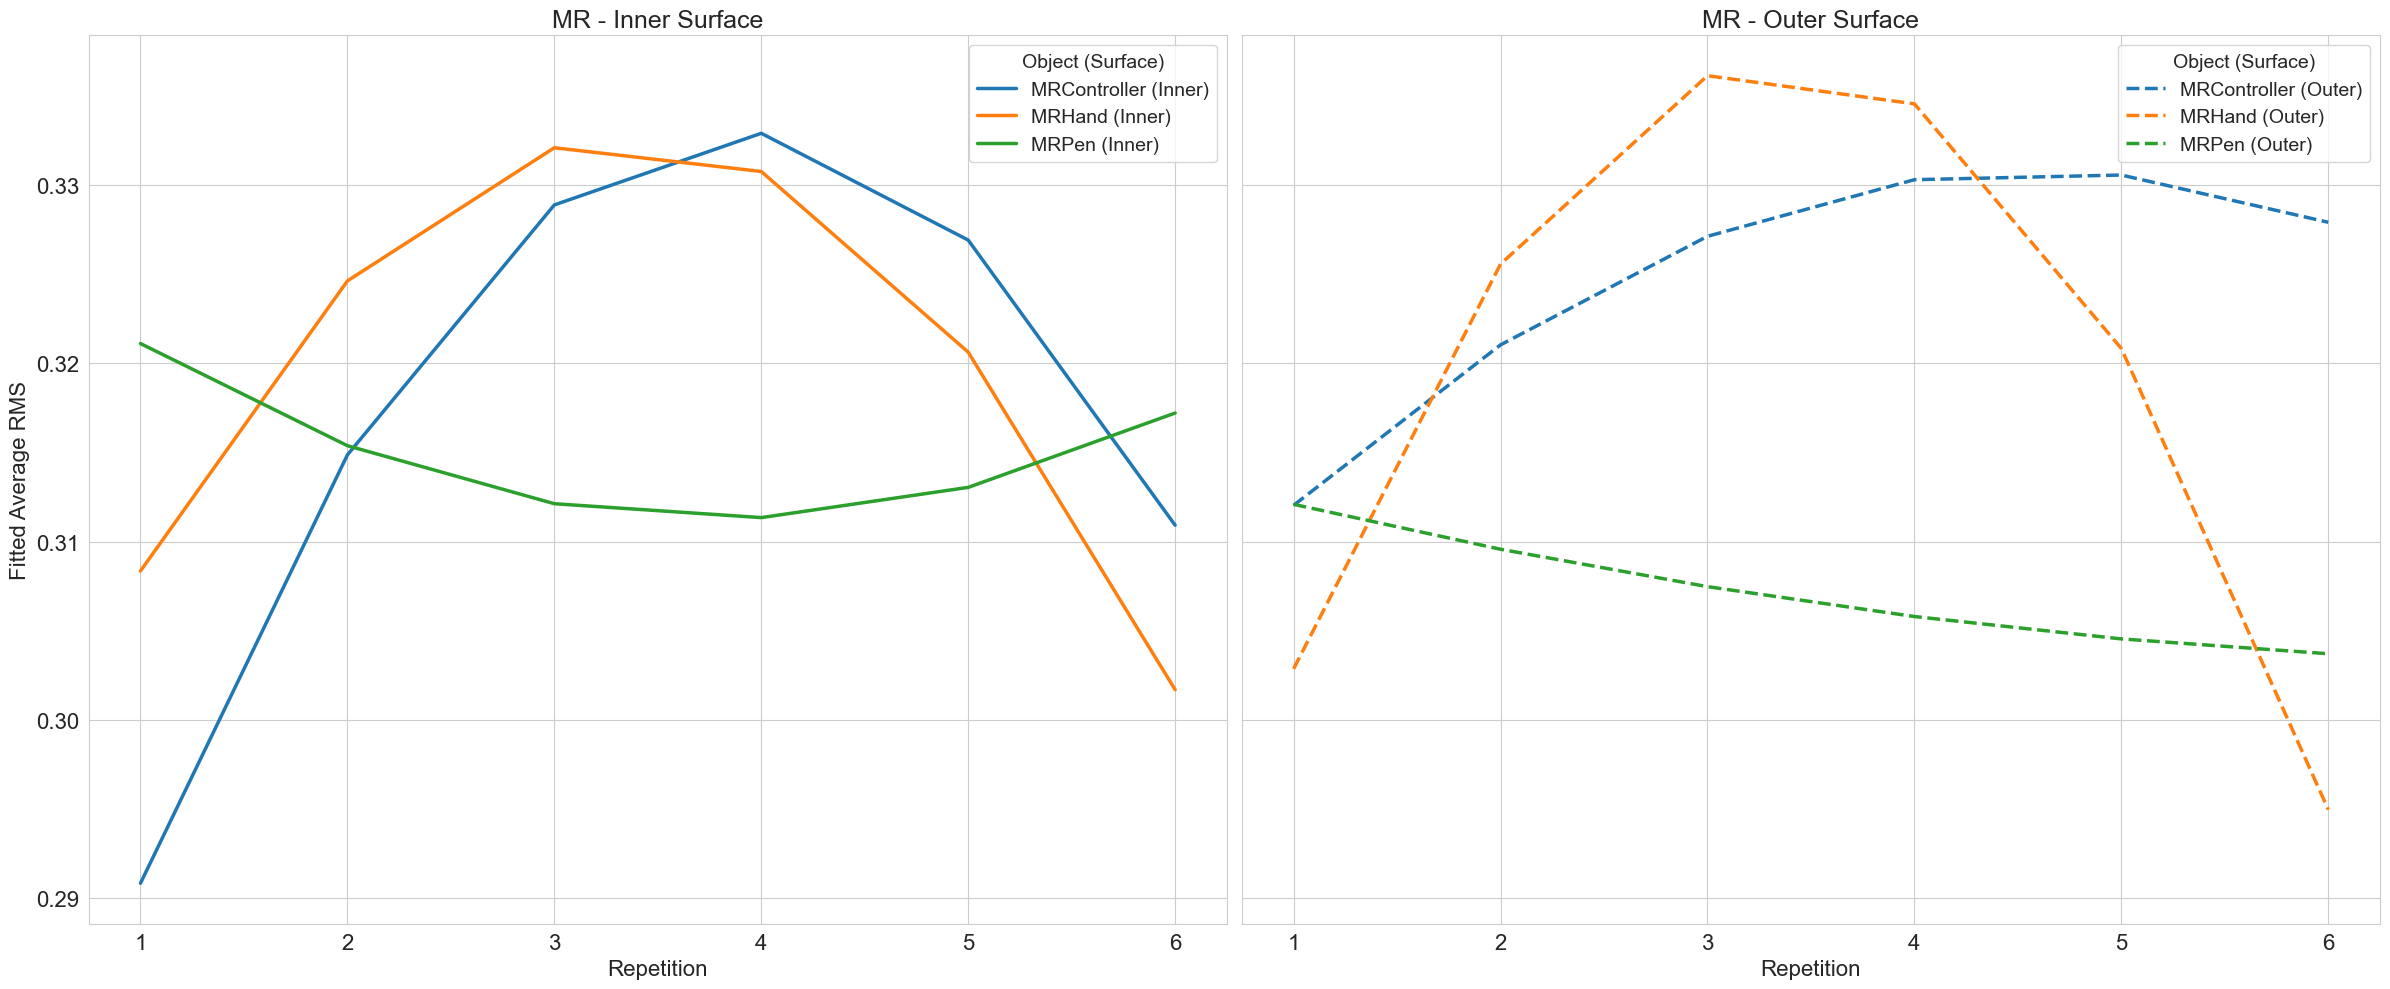

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), sharey=True) 
sns.set_style("whitegrid")

color_palette = sns.color_palette("tab10", len(df['Object'].unique()))
color_mapping = dict(zip(df['Object'].unique(), color_palette))

y_axis_min = 0.22
y_axis_max = 0.37


line_width = 2.5  
font_size = 16    
legend_font_size = 14  
title_font_size = 18

for i, surface in enumerate(df['Surface'].unique()):
    print(f"Processing surface: {surface}")  # Print the current surface

    # Filter data for the specific surface
    data_surface = df[df['Surface'] == surface]

    for object in data_surface['Object'].unique():
        # Filter data for the specific object
        data_object = data_surface[data_surface['Object'] == object]

        print(f"  Processing object: {object}")

        # Aggregate data by 'Repetition', calculate the mean of 'ChannelAvg'
        data_object = data_object.groupby('Repetition')['ChannelAvg'].mean().reset_index()

        # Fit a polynomial of degree POLYFIT_DEGREE to the data
        coefficients = np.polyfit(data_object['Repetition'], data_object['ChannelAvg'], POLYFIT_DEGREE)
        polynomial = np.poly1d(coefficients)
        trendline = polynomial(data_object['Repetition'])

        if np.isnan(trendline).any():  # Check if trendline contains NaN
            print(f"Warning: trendline for object {object} on surface {surface} contains NaN values")

        linestyle = '-' if surface == 'Inner' else '--'
        sns.lineplot(ax=axes[i], x=data_object['Repetition'], y=trendline, label=f"{object} ({surface})",
                     color=color_mapping[object], linestyle=linestyle, linewidth=line_width)

    #axes[i].set_ylim(y_axis_min, y_axis_max)
    axes[i].set_title(f'{MODE} - {surface} Surface', fontsize=title_font_size)
    axes[i].set_xlabel('Repetition', fontsize=font_size)
    axes[i].set_ylabel('Fitted Average RMS', fontsize=font_size)
    axes[i].tick_params(labelsize=font_size)
    axes[i].legend(title='Object (Surface)', title_fontsize=legend_font_size, fontsize=legend_font_size, loc='best')

plt.tight_layout()
plt.savefig(f'figure/EMG/Aggregation/Trendline/Test/V3/{MODE}_combined_subplot_filter_{"filtered" if ENABLE_FILTER else "raw"}.png')
plt.show()
